In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
PARENT_PATH = "/content/drive/MyDrive/CSE-284-Final-Project"

In [8]:
! wget https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
! unzip plink_linux_x86_64_20231211.zip
! ./plink

--2024-03-07 22:04:31--  https://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20231211.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.161.240, 54.231.162.216, 52.216.212.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.161.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8953953 (8.5M) [application/zip]
Saving to: ‘plink_linux_x86_64_20231211.zip’

plink_linux_x86_64_ 100%[===================>]   8.54M  14.8MB/s    in 0.6s    

2024-03-07 22:04:32 (14.8 MB/s) - ‘plink_linux_x86_64_20231211.zip’ saved [8953953/8953953]

Archive:  plink_linux_x86_64_20231211.zip
  inflating: plink                   
  inflating: LICENSE                 
  inflating: toy.ped                 
  inflating: toy.map                 
  inflating: prettify                
PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink <input flag(s

In [9]:
sh = """

PARENT_PATH=/content/drive/MyDrive/CSE-284-Final-Project
TRAIN=${PARENT_PATH}/data/test_data/CEU_chr19_normed
VALID=${PARENT_PATH}/data/test_data/GBR_chr19_normed
PHEN=${PARENT_PATH}/data/test_data/kgvcf_ldl.pheno

./plink --bfile $TRAIN \
   --pheno $PHEN \
   --linear \
   --double-id \
   --allow-no-sex \
   --maf 0.05 \
   --out CEU

./plink --bfile $TRAIN \
   --freq \
   --out CEU

cat CEU.assoc.linear | awk '( (($7<10) && ($7!="NA")) || ($1~/CHR/))' > CEU.assoc.linear.filt

# Clump things with r2>0.1 and within 250kb
./plink \
    --bfile $TRAIN \
    --clump-p1 1 \
    --clump-r2 0.1 \
    --clump-kb 250 \
    --clump CEU.assoc.linear.filt \
    --out CEU

awk 'NR!=1{print $3}' CEU.clumped > CEU.valid.snp
cat CEU.clumped | awk '{print $3 "\t" $5}' > CEU.pvals

# Construct the file with a list of p-value
# ranges to consider
# We include p-value thresholds 0.000001, 0.00001, 0.0001, 0.001, 0.05 and 0.1
# Syntax is: name, min pval, max pval

echo "0.000001 0 0.000001" > range_list
echo "0.00001 0 0.00001" >> range_list
echo "0.0001 0 0.0001" >> range_list
echo "0.001 0 0.001" >> range_list
echo "0.05 0 0.05" >> range_list
echo "0.1 0 0.1" >> range_list

# Generate the scores
# You might get warnings about mismatch variant IDs
# We will ignore these here but in real life should investigate those...
# Note we are actually scoring the GBR samples. We'll get a score
# for each sample in the --vcf input file.
# But our score (the SNPs and weights) are based off of the GWAS in CEU.

./plink \
    --bfile $VALID \
    --score CEU.assoc.linear.filt 2 4 7 header sum \
    --q-score-range range_list CEU.pvals \
    --extract CEU.valid.snp \
    --out CEU_C+T_GBR

"""
with open('script.sh', 'w') as file:
  file.write(sh)

! bash script.sh

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU.log.
Options in effect:
  --allow-no-sex
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/test_data/CEU_chr19_normed
  --double-id
  --linear
  --maf 0.05
  --out CEU
  --pheno /content/drive/MyDrive/CSE-284-Final-Project/data/test_data/kgvcf_ldl.pheno

12978 MB RAM detected; reserving 6489 MB for main workspace.
242500 variants loaded from .bim file.
99 people (0 males, 0 females, 99 ambiguous) loaded from .fam.
Ambiguous sex IDs written to CEU.nosex .
99 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 99 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%

In [ ]:
# sh = """

# PARENT_PATH=/content/drive/MyDrive/CSE-284-Final-Project
# TRAIN=${PARENT_PATH}/data/1000g_by_superpopulation/AFR_train
# PHEN=${PARENT_PATH}/data/1000g_pheno_updated/power=-0.25_her=0.1_num-causals=100.phen

# ./plink2 --bfile $TRAIN \
#    --pheno $PHEN \
#    --no-fam-pheno \
#    --linear allow-no-covars \
#    --allow-no-sex \
#    --maf 0.05 \
#    --out test

# """
# with open('script.sh', 'w') as file:
#   file.write(sh)

# ! bash script.sh

PLINK v2.00a5.10LM 64-bit Intel (5 Jan 2024)   www.cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to test.log.
Options in effect:
  --allow-no-sex
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_superpopulation/AFR_train
  --glm allow-no-covars
  --maf 0.05
  --no-psam-pheno
  --out test
  --pheno /content/drive/MyDrive/CSE-284-Final-Project/data/1000g_pheno_updated/power=-0.25_her=0.1_num-causals=100.phen

Start time: Thu Mar  7 08:40:04 2024
Note: --allow-no-sex no longer has any effect.  (Missing-sex samples are
automatically excluded from association analysis when sex is a covariate, and
treated normally otherwise.)
12978 MiB RAM detected, ~11672 available; reserving 6489 MiB for main
workspace.
Using up to 2 compute threads.
523 samples (267 females, 256 males; 520 founders) loaded from
/content/drive/MyDrive/CSE-284-Final-Project/data/1000g_by_superpopulation/AFR_train.fam.
10568687 variants 

In [ ]:
# sh = """

# PARENT_PATH=/content/drive/MyDrive/CSE-284-Final-Project
# VCF=${PARENT_PATH}/data/test_data/CEU_chr19_normed.vcf.gz
# VALID=${PARENT_PATH}/data/test_data/GBR_chr19_normed.vcf.gz
# PHEN=${PARENT_PATH}/data/test_data/kgvcf_ldl.phen

# ./plink2 --vcf $VCF \
#    --pheno $PHEN \
#    --linear \
#    --double-id \
#    --allow-no-sex \
#    --maf 0.05 \
#    --out CEU

# ./plink --vcf $VCF \
#    --freq \
#    --out CEU

# cat CEU.assoc.linear | awk '( (($7<10) && ($7!="NA")) || ($1~/CHR/))' > CEU.assoc.linear.filt

# # Clump things with r2>0.1 and within 250kb
# ./plink \
#     --vcf $VCF \
#     --clump-p1 1 \
#     --clump-r2 0.1 \
#     --clump-kb 250 \
#     --clump CEU.assoc.linear.filt \
#     --out CEU

# awk 'NR!=1{print $3}' CEU.clumped > CEU.valid.snp
# cat CEU.clumped | awk '{print $3 "\t" $5}' > CEU.pvals

# # Construct the file with a list of p-value
# # ranges to consider
# # We include p-value thresholds 0.000001, 0.00001, 0.0001, 0.001, 0.05 and 0.1
# # Syntax is: name, min pval, max pval

# echo "0.000001 0 0.000001" > range_list
# echo "0.00001 0 0.00001" >> range_list
# echo "0.0001 0 0.0001" >> range_list
# echo "0.001 0 0.001" >> range_list
# echo "0.05 0 0.05" >> range_list
# echo "0.1 0 0.1" >> range_list

# # Generate the scores
# # You might get warnings about mismatch variant IDs
# # We will ignore these here but in real life should investigate those...
# # Note we are actually scoring the GBR samples. We'll get a score
# # for each sample in the --vcf input file.
# # But our score (the SNPs and weights) are based off of the GWAS in CEU.

# ./plink \
#     --vcf $VALID \
#     --score CEU.assoc.linear.filt 2 4 7 header sum \
#     --q-score-range range_list CEU.pvals \
#     --extract CEU.valid.snp \
#     --out CEU_C+T_GBR

# """
# with open('script.sh', 'w') as file:
#   file.write(sh)

# ! bash script.sh

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU.log.
Options in effect:
  --allow-no-sex
  --double-id
  --linear
  --maf 0.05
  --out CEU
  --pheno /content/drive/MyDrive/CSE-284-Final-Project/data/test_data/kgvcf_ldl.phen
  --vcf /content/drive/MyDrive/CSE-284-Final-Project/data/test_data/CEU_chr19_normed.vcf.gz

12978 MB RAM detected; reserving 6489 MB for main workspace.
--vcf: CEU-temporary.bed + CEU-temporary.bim + CEU-temporary.fam written.
1830285 variants loaded from .bim file.
99 people (0 males, 0 females, 99 ambiguous) loaded from .fam.
Ambiguous sex IDs written to CEU.nosex .
99 phenotype values present after --pheno.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 99 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16

In [ ]:
! cp CEU_C+T* /content/drive/MyDrive/CSE-284-Final-Project/data/test_data/C+T/

In [ ]:
! pip install qqman

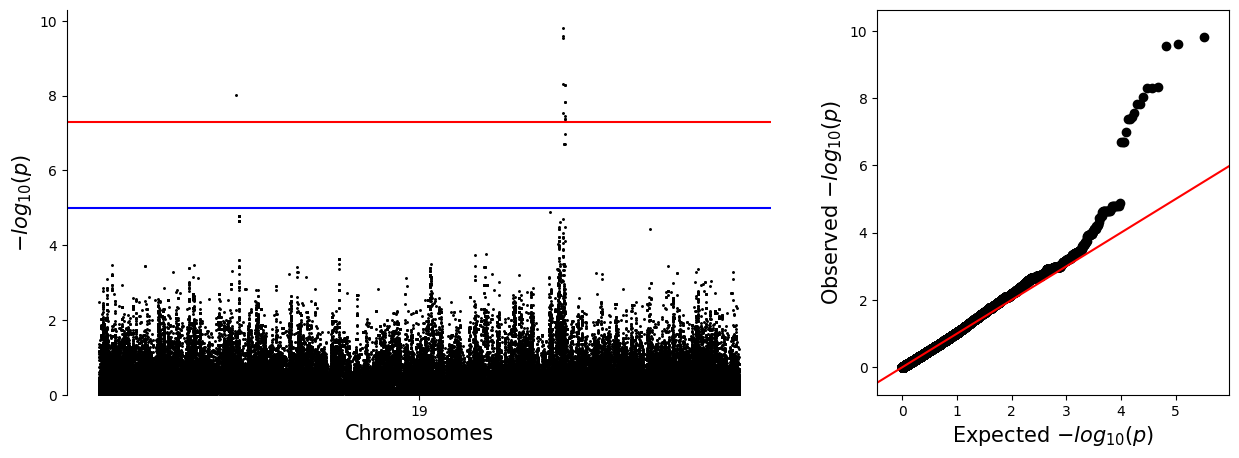

In [ ]:
import os
import pandas as pd
from qqman import qqman
import matplotlib.pyplot as plt


data = pd.read_csv("CEU.assoc.linear", delim_whitespace=True)
data = data[data["P"]>0] # remove 0s for plotting
fig, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
fig.set_size_inches((15, 5))
qqman.manhattan(data, ax=ax0)
qqman.qqplot(data, ax=ax1)

In [10]:
sh = """

PARENT_PATH=/content/drive/MyDrive/CSE-284-Final-Project
TRAIN=${PARENT_PATH}/data/test_data/CEU_chr19_normed
PHEN=${PARENT_PATH}/data/test_data/kgvcf_ldl.pheno

./plink \
    --bfile $TRAIN \
    --score CEU.assoc.linear.filt 2 4 7 header sum \
    --q-score-range range_list CEU.pvals \
    --extract CEU.valid.snp \
    --out CEU_C+T_CEU

"""
with open('script.sh', 'w') as file:
  file.write(sh)

! bash script.sh

PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to CEU_C+T_CEU.log.
Options in effect:
  --bfile /content/drive/MyDrive/CSE-284-Final-Project/data/test_data/CEU_chr19_normed
  --extract CEU.valid.snp
  --out CEU_C+T_CEU
  --q-score-range range_list CEU.pvals
  --score CEU.assoc.linear.filt 2 4 7 header sum

12978 MB RAM detected; reserving 6489 MB for main workspace.
242500 variants loaded from .bim file.
99 people (0 males, 0 females, 99 ambiguous) loaded from .fam.
Ambiguous sex IDs written to CEU_C+T_CEU.nosex .
--extract: 6253 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 99 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%3

In [22]:
import pandas as pd
import scipy.stats
print("CEU - test on CEU")

for pval in ["0.000001", "0.00001", "0.0001", "0.001", "0.05", "0.1"]:
    prs = pd.read_csv("CEU_C+T_CEU.%s.profile"%pval, delim_whitespace=True)
    phen = pd.read_csv("/content/drive/MyDrive/CSE-284-Final-Project/data/test_data/kgvcf_ldl.pheno",
                   delim_whitespace=True, names=["FID","IID","phen"])
    d = pd.merge(prs, phen, on=["IID"])
    print("pval=%s, R2=%s"%(pval, scipy.stats.pearsonr(d["phen"],d["SCORESUM"])[0]**2))

CEU - test on CEU
pval=0.000001, R2=0.6941601568702669
pval=0.00001, R2=0.6941601568702669
pval=0.0001, R2=0.771722130782003
pval=0.001, R2=0.8724947425162807
pval=0.05, R2=0.9779673344649921
pval=0.1, R2=0.9781459038505037


In [23]:
import pandas as pd
import scipy.stats
print("CEU - test on GBR")

for pval in ["0.000001", "0.00001", "0.0001", "0.001", "0.05", "0.1"]:
    prs = pd.read_csv("CEU_C+T_GBR.%s.profile"%pval, delim_whitespace=True)
    phen = pd.read_csv("/content/drive/MyDrive/CSE-284-Final-Project/data/test_data/kgvcf_ldl.pheno",
                   delim_whitespace=True, names=["FID","IID","phen"])
    d = pd.merge(prs, phen, on=["IID"])
    print("pval=%s, R2=%s"%(pval, scipy.stats.pearsonr(d["phen"],d["SCORESUM"])[0]**2))

CEU - test on GBR
pval=0.000001, R2=0.5608043472385226
pval=0.00001, R2=0.5608043472385226
pval=0.0001, R2=0.6411252172617482
pval=0.001, R2=0.27761766402903604
pval=0.05, R2=0.1624804404370466
pval=0.1, R2=0.1515782394089207


In [3]:
! apt-get install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (67.5 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [6]:
! tree /content/drive/MyDrive/CSE-284-Final-Project/ -L 3

/content/drive/MyDrive/CSE-284-Final-Project/
├── data
│   ├── 1000g_by_population
│   │   ├── ACB_all.bed
│   │   ├── ACB_all.bim
│   │   ├── ACB_all.fam
│   │   ├── ACB_all.log
│   │   ├── ACB_all.pgen
│   │   ├── ACB_all.psam
│   │   ├── ACB_all.pvar.zst
│   │   ├── ASW_all.bed
│   │   ├── ASW_all.bim
│   │   ├── ASW_all.fam
│   │   ├── ASW_all.log
│   │   ├── ASW_all.pgen
│   │   ├── ASW_all.psam
│   │   ├── ASW_all.pvar.zst
│   │   ├── BEB_all.bed
│   │   ├── BEB_all.bim
│   │   ├── BEB_all.fam
│   │   ├── BEB_all.log
│   │   ├── BEB_all.pgen
│   │   ├── BEB_all.psam
│   │   ├── BEB_all.pvar.zst
│   │   ├── CDX_all.bed
│   │   ├── CDX_all.bim
│   │   ├── CDX_all.fam
│   │   ├── CDX_all.log
│   │   ├── CDX_all.pgen
│   │   ├── CDX_all.psam
│   │   ├── CDX_all.pvar.zst
│   │   ├── CEU_all.bed
│   │   ├── CEU_all.bim
│   │   ├── CEU_all.fam
│   │   ├── CEU_all.log
│   │   ├── CEU_all.pgen
│   │   ├── CEU_all.psam
│   │   ├── CEU_all.pvar.zst
│   │   ├── CHB_all.bed
│   │   ├── CHB_al